In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [ ]:
batch_size = 32
img_height = 500
img_width = 500
filepath='/content/drive/MyDrive/PrasoonCodes/dataset'
#trainig dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  filepath,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,)

#validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  filepath,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,)


Found 330 files belonging to 2 classes.
Using 264 files for training.
Found 330 files belonging to 2 classes.
Using 66 files for validation.


In [ ]:
#Visualizing the dataset
class_names = train_ds.class_names
'''plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")'''

'plt.figure(figsize=(10, 10))\nfor images, labels in train_ds.take(1):\n  for i in range(9):\n    ax = plt.subplot(3, 3, i + 1)\n    plt.imshow(images[i].numpy().astype("uint8"))\n    plt.title(class_names[labels[i]])\n    plt.axis("off")'

In [ ]:
#Caching the dataset
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#data augmentation
from tensorflow.keras import *
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#visualizing the data augmentation
'''plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")'''

'plt.figure(figsize=(10, 10))\nfor images, _ in train_ds.take(1):\n  for i in range(9):\n    augmented_images = data_augmentation(images)\n    ax = plt.subplot(3, 3, i + 1)\n    plt.imshow(augmented_images[0].numpy().astype("uint8"))\n    plt.axis("off")'

In [ ]:
#standarizing the data into 0 n 1s
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.04658989 0.87843144


In [ ]:
#creating the model
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
#model complie
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 500, 500, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 500, 500, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 500, 500, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 250, 250, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 125, 125, 32)      0         
 g2D)                                                 

In [ ]:
#training
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
9/9 [==============================] - 104s 11s/step - loss: 10.8771 - accuracy: 0.5114 - val_loss: 0.7251 - val_accuracy: 0.5606
Epoch 2/10
9/9 [==============================] - 86s 9s/step - loss: 0.7217 - accuracy: 0.4811 - val_loss: 0.6923 - val_accuracy: 0.5303
Epoch 3/10
9/9 [==============================] - 86s 9s/step - loss: 0.6931 - accuracy: 0.4811 - val_loss: 0.6927 - val_accuracy: 0.5455
Epoch 4/10
9/9 [==============================] - 92s 10s/step - loss: 0.6929 - accuracy: 0.4848 - val_loss: 0.6920 - val_accuracy: 0.5455
Epoch 5/10
9/9 [==============================] - 90s 10s/step - loss: 0.6938 - accuracy: 0.4811 - val_loss: 0.6971 - val_accuracy: 0.4394
Epoch 6/10
9/9 [==============================] - 87s 10s/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6896 - val_accuracy: 0.5152
Epoch 7/10
9/9 [==============================] - 85s 10s/step - loss: 0.6909 - accuracy: 0.4962 - val_loss: 0.6882 - val_accuracy: 0.5606
Epoch 8/10
9/9 [===========

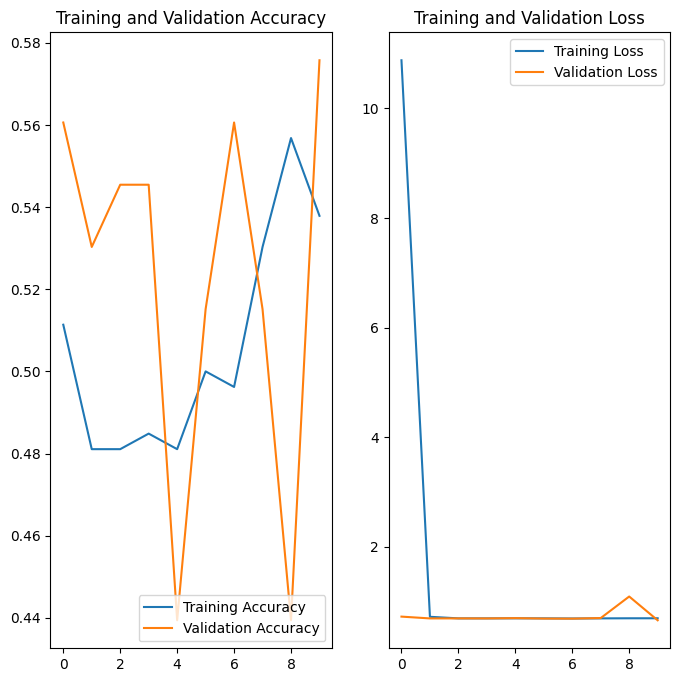

In [12]:
#visualizing
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
img = tf.keras.utils.load_img('/content/drive/MyDrive/PrasoonCodes/dataset/Non-Pixelated/animals/Animal8.jpg', target_size=(500, 500)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 392ms/step
This image most likely Non-Pixelated with a 54.25 percent confidence.


In [15]:
#saving the model
model.save('pixelatedimgdetection.keras')